In [ ]:
#import important libraries
import random

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from imgaug import augmenters

In [ ]:
#define terms and data path
# open("model.h5", "w")
# model_path = './model.h5'
monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 4)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()


def setup_field_data(data):
    rand = random.uniform(-1, 1)

    for i in range(len(data)):
      image = data[i]

      if abs(rand) < 0.5:
        image = augmenters.Affine(rotate = rand * 40).augment_image(image)
      elif abs(rand) < 0.8:
        image = augmenters.Affine(shear = rand * 40).augment_image(image)
      data[i] = image
    return data

In [ ]:
#download data
# the !wget only needs to happen once to download the files
if(os.path.exists('image_data.npy')==False):
  !wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"
if(os.path.exists('metadata.csv')==False):
  !wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"


### pre-loading all data of interest
image_data = np.load('image_data.npy')
labels_path  = 'metadata.csv'
labels_data = pd.read_csv(labels_path)
# downloading and loading data

############## define data
### field data
field_start_index = labels_data.groupby('split').get_group('field')['index'].to_numpy()[0]
field_end_index = labels_data.groupby('split').get_group('field')['index'].to_numpy()[-1]+1#plus one ensures it ends correctly

field_data = image_data[field_start_index:field_end_index]
field_data = setup_field_data(field_data)#randomly rotates the images and stretches them

field_labels = labels_data['class'].to_numpy()[field_start_index:field_end_index]
### train data
train_start_index = labels_data.groupby('split').get_group('train')['index'].to_numpy()[0]
train_end_index = labels_data.groupby('split').get_group('train')['index'].to_numpy()[-1]+1#plus one ensures it ends correctly

train_data = image_data[train_start_index:train_end_index]

train_labels = labels_data['class'].to_numpy()[train_start_index:train_end_index]

--2022-07-28 19:01:25--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137625728 (131M) [application/octet-stream]
Saving to: ‘image_data.npy’

image_data.npy      100%[===================>] 131.25M   132MB/s    in 1.0s    

2022-07-28 19:01:26 (132 MB/s) - ‘image_data.npy’ saved [137625728/137625728]

--2022-07-28 19:01:27--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Conn

In [ ]:
#setup our data
rotate1 = augmenters.Affine(rotate = 10).augment_images(train_data)
scale1 = augmenters.Affine(scale = 1.3).augment_images(train_data)
shear1 = augmenters.Affine(shear = 20).augment_images(train_data)
updown1 = augmenters.Flipud(p = 1.0).augment_images(train_data)
leftright1 = augmenters.Fliplr(p = 1.0).augment_images(train_data)

mod_data = np.concatenate([train_data, rotate1, scale1, shear1, updown1, leftright1, field_data], axis = 0)
mod_labels = np.concatenate([train_labels, train_labels, train_labels, train_labels, train_labels, train_labels, field_labels], axis = 0)
X_train, X_test, y_train, y_test = train_test_split(mod_data, mod_labels, test_size=0.2, random_state=101)

Epoch 1/10
1984/1984 [==============================] - 23s 4ms/step - loss: 0.6400 - accuracy: 0.6496 - val_loss: 0.5443 - val_accuracy: 0.7581
Epoch 2/10
1984/1984 [==============================] - 8s 4ms/step - loss: 0.4372 - accuracy: 0.8055 - val_loss: 0.4313 - val_accuracy: 0.8621
Epoch 3/10
1984/1984 [==============================] - 8s 4ms/step - loss: 0.3118 - accuracy: 0.8745 - val_loss: 0.3330 - val_accuracy: 0.8984
Epoch 4/10
1984/1984 [==============================] - 14s 7ms/step - loss: 0.2664 - accuracy: 0.8998 - val_loss: 0.2497 - val_accuracy: 0.9226
Epoch 5/10
1984/1984 [==============================] - 9s 4ms/step - loss: 0.2301 - accuracy: 0.9116 - val_loss: 0.1860 - val_accuracy: 0.9407
Epoch 6/10
1984/1984 [==============================] - 10s 5ms/step - loss: 0.2145 - accuracy: 0.9191 - val_loss: 0.2340 - val_accuracy: 0.9343
Epoch 7/10
1984/1984 [==============================] - 8s 4ms/step - loss: 0.2014 - accuracy: 0.9252 - val_loss: 0.2514 - val_accura

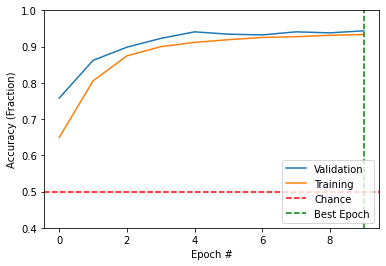

In [ ]:
#our model is sequential
cnn = Sequential()

cnn.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))#32 kernels each 3x3 with relu activator cause pixel values cannot be negative
cnn.add(Dropout(0.5))
cnn.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu'))#16 kernels each 3x3 with relu activator cause pixel values cannot be negative
cnn.add(Dropout(0.5))

cnn.add(MaxPooling2D(pool_size=(2,2)))#pool size of 2x2 means it looks at a 2x2 area of pixels and picks the most prominent one

#turns array to 1d etc [1,2,3,1,3,1,4,5,6]
cnn.add(Flatten(input_shape=(64, 64, 3)))
cnn.add(Dropout(0.5))#turns off 50% of neurons above

cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(1, activation='sigmoid'))#sigmoid is binary outputs softmax is more categories

#####################################################################################################################
#opt = keras.optimizers.RMSprop(learning_rate=1e-5, decay=1e-6)
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = cnn.fit(X_train, y_train,
                          epochs = 10,
                          batch_size = 5,
                          validation_data = (X_test, y_test),
                          shuffle = True,
                          callbacks = [monitor])
#####################################################################################################################
plot_acc(history)

percent the image has pneumonia: 8.128676563501358


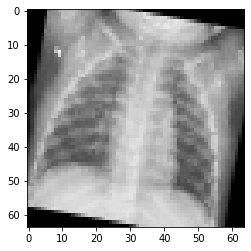

In [ ]:
plt.imshow(X_test[33])
print("percent the image has pneumonia:", cnn.predict(X_test[33:34])[0][0]*100)
# predicts image 33 through the whole array of image 33 stopping right before image 34
# #basically selects the whole image at index 33 im dumb

your cnn's correctness: 0.9705


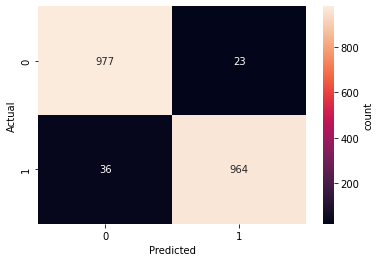

In [ ]:
#visualisze data with a confucius matrix
unused_start_index = labels_data.groupby('split').get_group('train')['index'].to_numpy()[0]
unused_end_index = labels_data.groupby('split').get_group('train')['index'].to_numpy()[-1]+1#plus one ensures it ends correctly

unused_data = image_data[unused_start_index:unused_end_index]
unused_labels = labels_data['class'].to_numpy()[unused_start_index:unused_end_index]

predictions = cnn.predict(unused_data)
predictions = predictions > .5

confusion = confusion_matrix(unused_labels, predictions)
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});

plt.ylabel('Actual');
plt.xlabel('Predicted');

tl = confusion[0][0]#top left
tr = confusion[0][1]#top right
br = confusion[1][1]#bottom right
bl = confusion[1][0]#bottom left
average = (tl+br)/(tl+tr+br+bl)
print("your cnn's correctness:", average)

enter image filename : download.png
has pneumonia: [[ True]]


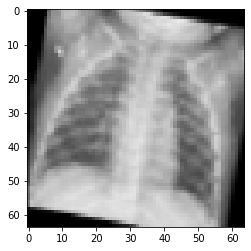

In [ ]:
#######import and predict any x ray image you want
from PIL import Image
import cv2
#what is centercropping?
img_filepath = input("enter image filename : ")

#this is for pngs only
# png = Image.open(img_filepath).convert('RGBA')
# background = Image.new('RGBA', png.size, (255,255,255))
# alpha_composite = Image.alpha_composite(background, png)

# mod_image = alpha_composite.resize((64, 64))
# mod_image = np.asarray(mod_image)[:,:,:3]
# plt.imshow(mod_image)

#better png
mod_image = Image.open(img_filepath).resize((64, 64))
mod_image = mod_image.convert('RGB')
mod_image = np.asarray(mod_image)
plt.imshow(mod_image)

mod_image = np.array(mod_image).reshape(1, 64, 64, 3)
pred = cnn.predict(mod_image)
print("has pneumonia:",pred>0.5)